<a href="https://colab.research.google.com/github/DeuklyoungKo/TensorFlowBasicWithPython/blob/main/Tensorflow/08_KerasTuner.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
from tensorflow import keras

import IPython

In [3]:
!pip install -q -U keras-tuner
import keras_tuner as kt

In [4]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

4431872/4422102 [==============================] - 0s 0us/step


In [6]:
# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

In [7]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])

  return model

In [8]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_accuracy', 
                     max_epochs = 10,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

In [9]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [10]:
tuner.search(img_train, label_train, epochs = 10, validation_data = (img_test, label_test), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 30 Complete [00h 01m 22s]
val_accuracy: 0.7555999755859375

Best val_accuracy So Far: 0.8790000081062317
Total elapsed time: 00h 18m 37s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 320 and the optimal learning rate for the optimizer
is 0.01.



In [13]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
history = model.fit(img_train, label_train, epochs = 10, validation_data = (img_test, label_test))

Epoch 1/10
1875/1875 [==============================] - 9s 4ms/step - loss: 0.5818 - accuracy: 0.7877 - val_loss: 0.4592 - val_accuracy: 0.8361
Epoch 2/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.4197 - accuracy: 0.8490 - val_loss: 0.4454 - val_accuracy: 0.8381
Epoch 3/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3840 - accuracy: 0.8598 - val_loss: 0.4315 - val_accuracy: 0.8389
Epoch 4/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3567 - accuracy: 0.8698 - val_loss: 0.4332 - val_accuracy: 0.8451
Epoch 5/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3381 - accuracy: 0.8751 - val_loss: 0.3733 - val_accuracy: 0.8678
Epoch 6/10
1875/1875 [==============================] - 9s 5ms/step - loss: 0.3236 - accuracy: 0.8802 - val_loss: 0.3891 - val_accuracy: 0.8581
Epoch 7/10
1875/1875 [==============================] - 8s 4ms/step - loss: 0.3105 - accuracy: 0.8841 - val_loss: 0.3829 - val_accuracy:

In [27]:
base_history = history
base_history

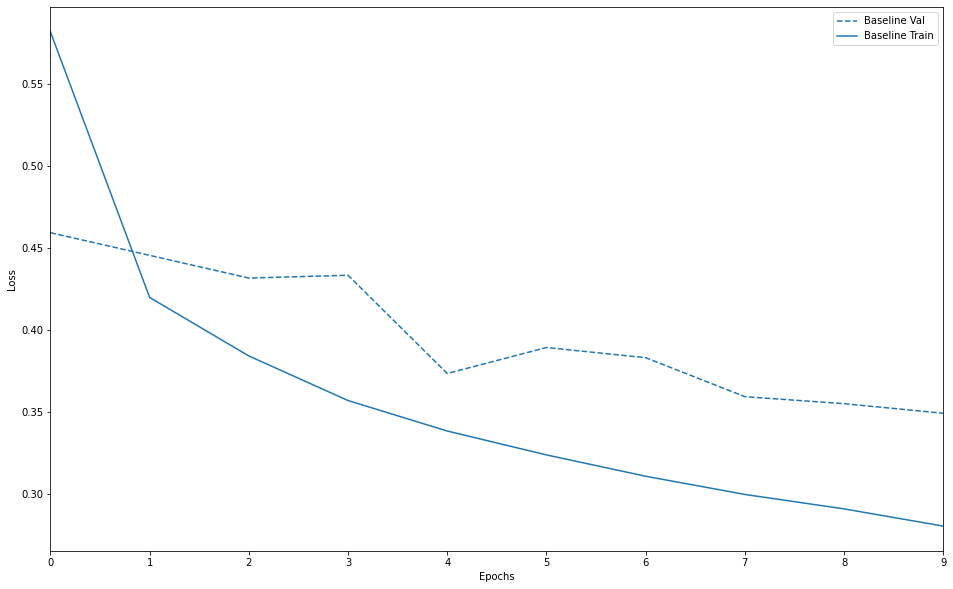

In [29]:
import matplotlib.pyplot as plt

def plot_history(histories, key='loss'):
  plt.figure(figsize=(16,10))

  for name, history in histories:
    val = plt.plot(history.epoch, history.history['val_'+key],
                   '--', label=name.title()+' Val')
    plt.plot(history.epoch, history.history[key], color=val[0].get_color(),
             label=name.title()+' Train')

  plt.xlabel('Epochs')
  plt.ylabel(key.replace('_',' ').title())
  plt.legend()

  plt.xlim([0,max(history.epoch)])


plot_history([('baseline', base_history)])